In [255]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
#from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

# Set up and design the project

In [115]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [116]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [117]:
%%time
DLC_social_1 = project(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.73 s, sys: 951 ms, total: 3.68 s
Wall time: 1.32 s


# Run project

In [118]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9.72 s, sys: 717 ms, total: 10.4 s
Wall time: 10.7 s


source.classes.coordinates

# Generate coords

In [119]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest._type

CPU times: user 812 ms, sys: 72.7 ms, total: 884 ms
Wall time: 854 ms


'coords'

In [120]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

CPU times: user 546 ms, sys: 391 ms, total: 936 ms
Wall time: 938 ms


'dists'

In [121]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

CPU times: user 143 ms, sys: 93 ms, total: 236 ms
Wall time: 264 ms


'angles'

# Visualization playground

In [ ]:
ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [ ]:
#Plot animation of trajectory over time with different smoothings
plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Mouse Center Trajectory using different exponential smoothings')
plt.legend()
plt.show()

# Dimensionality reduction playground

In [ ]:
pca = ptest.pca(4, 1000)

In [ ]:
plt.scatter(*pca[0].T)
plt.show()

# Preprocessing playground

In [12]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [13]:
#pptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [170]:
pttest = mtest.preprocess(window_size=51, filter=None)
pttest.shape

(704997, 51, 28)

In [ ]:
plt.plot(pttest[2,:,2], label='normal')
plt.plot(pptest[2,:,2], label='gaussian')
plt.legend()
plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [154]:
pttest = pttest[:1000]

In [240]:
CONV_filters = 64
LSTM_units_1 = 128
LSTM_units_2 = 64
DENSE_1 = 64
DENSE_2 = 32
ENCODING = 20
DROPOUT_RATE = 0.2

original_dim = pttest.shape[1:]
batch_size = 256

In [241]:
from source.hypermodels import *
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, Bidirectional, LSTM
from tensorflow.keras import backend as K

# Encoder Layers
Model_E0 = tf.keras.layers.Conv1D(
    filters=CONV_filters,
    kernel_size=5,
    strides=1,
    padding="causal",
    activation="relu",
)
Model_E1 = Bidirectional(
    LSTM(
        LSTM_units_1,
        activation="tanh",
        return_sequences=True,
        kernel_constraint=UnitNorm(axis=0),
    )
)
Model_E2 = Bidirectional(
    LSTM(
        LSTM_units_2,
        activation="tanh",
        return_sequences=False,
        kernel_constraint=UnitNorm(axis=0),
    )
)
Model_E3 = Dense(DENSE_1, activation="relu", kernel_constraint=UnitNorm(axis=0))
Model_E4 = Dense(DENSE_2, activation="relu", kernel_constraint=UnitNorm(axis=0))
Model_E5 = Dense(
            ENCODING,
            activation="relu",
            kernel_constraint=UnitNorm(axis=1),
            activity_regularizer=UncorrelatedFeaturesConstraint(3, weightage=1.0),
        )

# Decoder layers
Model_D4 = Bidirectional(
    LSTM(
        LSTM_units_1,
        activation="tanh",
        return_sequences=True,
        kernel_constraint=UnitNorm(axis=1),
    )
)
Model_D5 = Bidirectional(
    LSTM(
        LSTM_units_1,
        activation="sigmoid",
        return_sequences=True,
        kernel_constraint=UnitNorm(axis=1),
    )
)

# Define and instanciate encoder
x = Input(shape=original_dim)
encoder = Model_E0(x)
encoder = Model_E1(encoder)
encoder = Model_E2(encoder)
encoder = Model_E3(encoder)
encoder = Dropout(DROPOUT_RATE)(encoder)
encoder = Model_E4(encoder)
encoder = Model_E5(encoder)
z_mean = Dense(ENCODING)(encoder)
z_log_sigma = Dense(ENCODING)(encoder)

In [242]:
def sampling(args, epsilon_std=1.):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=K.shape(z_mean),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling)([z_mean, z_log_sigma])

In [243]:
# Define and instanciate decoder
decoder = DenseTranspose(Model_E5, activation="relu", output_dim=ENCODING)(z)
decoder = DenseTranspose(Model_E4, activation="relu", output_dim=DENSE_2)(decoder)
decoder = DenseTranspose(Model_E3, activation="relu", output_dim=DENSE_1)(decoder)
decoder = RepeatVector(pttest.shape[1])(decoder)
decoder = Model_D4(decoder)
decoder = Model_D5(decoder)
x_decoded_mean = TimeDistributed(Dense(original_dim[1]))(decoder)

In [244]:
# end-to-end autoencoder
klvae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(ENCODING,))
decoder = DenseTranspose(Model_E5, activation="relu", output_dim=ENCODING)(decoder_input)
decoder = DenseTranspose(Model_E4, activation="relu", output_dim=DENSE_2)(decoder)
decoder = DenseTranspose(Model_E3, activation="relu", output_dim=DENSE_1)(decoder)
decoder = RepeatVector(pttest.shape[1])(decoder)
decoder = Model_D4(decoder)
decoder = Model_D5(decoder)
x_decoded_mean = TimeDistributed(Dense(original_dim[1]))(decoder)
generator = Model(decoder_input, x_decoded_mean)

In [245]:
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 51, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 51, 64)       9024        input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 51, 256)      197632      conv1d_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 128)          164352      bidirectional_4[0][0]            
____________________________________________________________________________________________

In [246]:
tf.keras.utils.plot_model(vae)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [247]:
def compute_kernel(x, y):
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1] * K.shape(x)[2]
    tiled_x = K.tile(K.reshape(x, K.stack([x_size, 1, dim])), K.stack([1, y_size, 1]))
    tiled_y = K.tile(K.reshape(y, K.stack([1, y_size, dim])), K.stack([x_size, 1, 1]))
    return K.exp(-tf.reduce_mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [248]:
from tensorflow.keras.losses import Huber

def vae_loss(x, x_decoded_mean):
    huber_loss = Huber(reduction="sum", delta=100.0)
    huber_loss = original_dim * huber_loss(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(huber_loss + kl_loss[:, None])

def vae_mmd_loss(x, x_decoded_mean):
    huber_loss = Huber(reduction="sum", delta=100.0)
    huber_loss = original_dim * huber_loss(x, x_decoded_mean)
    mmd_loss = compute_mmd(x, x_decoded_mean)
    return huber_loss + mmd_loss

klvae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False, metrics=['mae'])

In [249]:
#tf.config.experimental_run_functions_eagerly(False)
#ptrain = pttest[np.random.choice(pttest.shape[0], 1000, replace=False), :, :]
klhistory = klvae.fit(ptrain, ptrain, epochs=50, batch_size=batch_size, verbose=1)

Train on 1000 samples
Epoch 1/50
1000/1000 [==============================] - ETA: 8s - loss: 8408979.0000 - mae: 0.854 - ETA: 3s - loss: 8002490.7500 - mae: 0.836 - ETA: 1s - loss: 7766003.5000 - mae: 0.828 - 6s 6ms/sample - loss: 7414377.2240 - mae: 0.8184
Epoch 2/50
1000/1000 [==============================] - ETA: 3s - loss: 7399954.0000 - mae: 0.809 - ETA: 2s - loss: 7397771.5000 - mae: 0.811 - ETA: 0s - loss: 7455063.1667 - mae: 0.815 - 4s 4ms/sample - loss: 7111586.0840 - mae: 0.8040
Epoch 3/50
1000/1000 [==============================] - ETA: 3s - loss: 6872538.5000 - mae: 0.789 - ETA: 2s - loss: 6902108.7500 - mae: 0.784 - ETA: 0s - loss: 7057614.0000 - mae: 0.790 - 4s 4ms/sample - loss: 6881130.4400 - mae: 0.7877
Epoch 4/50
1000/1000 [==============================] - ETA: 3s - loss: 6744250.5000 - mae: 0.760 - ETA: 2s - loss: 6800989.7500 - mae: 0.762 - ETA: 0s - loss: 6594802.0000 - mae: 0.749 - 4s 4ms/sample - loss: 6437221.5680 - mae: 0.7509
Epoch 5/50
1000/1000 [========

1000/1000 [==============================] - ETA: 3s - loss: 3257291.2500 - mae: 0.498 - ETA: 2s - loss: 3162630.8750 - mae: 0.489 - ETA: 1s - loss: 3233137.9167 - mae: 0.493 - 5s 5ms/sample - loss: 3116109.6540 - mae: 0.4890
Epoch 36/50
1000/1000 [==============================] - ETA: 4s - loss: 3286134.2500 - mae: 0.497 - ETA: 2s - loss: 3176050.3750 - mae: 0.489 - ETA: 1s - loss: 3101230.4167 - mae: 0.483 - 6s 6ms/sample - loss: 3041818.3680 - mae: 0.4834
Epoch 37/50
1000/1000 [==============================] - ETA: 4s - loss: 3259794.7500 - mae: 0.494 - ETA: 2s - loss: 3164856.3750 - mae: 0.485 - ETA: 1s - loss: 3119920.3333 - mae: 0.483 - 6s 6ms/sample - loss: 2998101.0580 - mae: 0.4792
Epoch 38/50
1000/1000 [==============================] - ETA: 4s - loss: 2828948.0000 - mae: 0.463 - ETA: 2s - loss: 3066356.0000 - mae: 0.480 - ETA: 1s - loss: 3029096.7500 - mae: 0.475 - 6s 6ms/sample - loss: 2973703.2700 - mae: 0.4763
Epoch 39/50
1000/1000 [==============================] - ETA

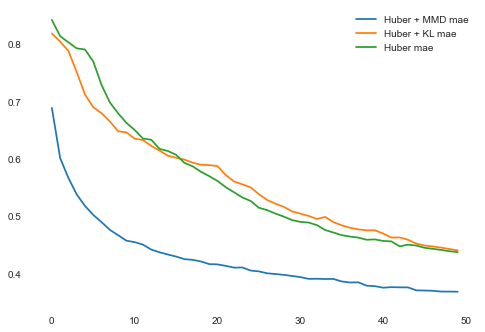

In [250]:
plt.plot(history.history['mae'], label='Huber + MMD mae')
plt.plot(klhistory.history['mae'], label='Huber + KL mae')
plt.plot(hhistory.history['mae'], label='Huber mae')

plt.legend()
plt.show()

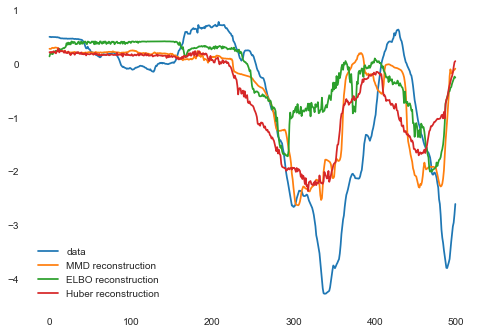

In [251]:
#Huber loss + MMD/ELBO in training data
plt.plot(pttest[:500,0,0], label='data')
plt.plot(vae.predict(pttest[:500])[:,0,0], label='MMD reconstruction')
plt.plot(klvae.predict(pttest[:500])[:,0,0], label='ELBO reconstruction')
plt.plot(hvae.predict(pttest[:500])[:,0,0], label='Huber reconstruction')

plt.legend()
plt.show()

In [259]:
assert 1==2, 'sos un gilillo'

AssertionError: sos un gilillo